## Overall Strategy: PCA + TimesFM for Feature Forecasting + Regression for RUL

1. Data Loading & RUL Calculation: Same as the previous example.
* Feature Selection: Select relevant sensor measurements and operational settings.

* Data Preprocessing (Scaling & PCA):
* * Scale selected features.
* * Apply PCA to reduce the dimensionality of the scaled features into a smaller set of Principal Components (PCs).
* * The PCA model should be fitted on the training data only.


1. TimesFM Forecasting of PCs:
** For each engine's time series, get the historical sequence of PCs.
Use the TimesFM foundation model to forecast the future values of these PCs for a defined prediction horizon. TimesFM operates on individual time series, so you'll forecast each PC series separately.
Important: TimesFM is designed for general time series forecasting, not specifically RUL. It will predict future values of your PCs.
Regression Model (PCs to RUL):
Train a separate regression model (e.g., RandomForestRegressor, LinearRegression, or a small Keras Dense network) that learns the mapping from current PC values to current RUL values. This model will use (current_PCs, current_RUL) pairs from the training data.
Prediction & Evaluation on Test Data:
For each test engine:
Take its historical sequence of PCs.
Use TimesFM to forecast its PCs for the desired horizon_len.
Take the last forecasted PC vector (or an aggregate of forecasted PCs, depending on your RUL prediction point).
Feed this forecasted PC vector into the trained regression model (from step 5) to predict the RUL.
Evaluate the predicted RUL against the true RUL.

In [237]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor # Example regression model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os 
# Import TimesFM
import timesfm
from timesfm import TimesFm, TimesFmHparams, TimesFmCheckpoint
import torch # TimesFM uses PyTorch backend

# --- 0. Configuration ---
# Ensure you have the CMAPSS data in a 'CMAPSSData' folder relative to your script.
# Download from NASA PCoE: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan
# Recommended: download 'CMAPSSData.zip', extract it.

# Define TimesFM parameters
CONTEXT_LEN = 128 # Max context length for TimesFM 1.0 (200M model)
HORIZON_LEN = 50  # How many future PCs to forecast for each series
FREQ = 1          # Frequency for CMAPSS cycles (1 unit per cycle)

# PCA parameters
N_COMPONENTS = 6  # Number of principal components to retain. Adjust based on explained variance.

# RUL calculation threshold (for training data)
RUL_THRESHOLD = 115

DATA_PATH =  r'/Users/pankajti/dev/data/kaggle/nasa/CMaps'


In [238]:
# --- 1. Data Loading & RUL Calculation ---

# Define column names
columns = ['unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + \
          [f'sensor_{i}' for i in range(1, 22)]

# Load FD001 data
try:
    train_path = os.path.join(DATA_PATH, 'train_FD003.txt')
    test_path = os.path.join(DATA_PATH, 'test_FD003.txt')
    rul_path = os.path.join(DATA_PATH, 'RUL_FD003.txt')

    train_df = pd.read_csv(train_path, sep=' ', header=None, names=columns, index_col=False)
    test_df = pd.read_csv(test_path, sep=' ', header=None, names=columns, index_col=False)
    rul_test_df = pd.read_csv(rul_path, sep=' ', header=None, names=['RUL'], index_col=False)
except FileNotFoundError:
    print("CMAPSS data not found. Please ensure 'CMAPSSData' folder is in the same directory as this script.")
    print("Download from: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan")
    exit() # Exit if files are not found


/var/folders/tz/k1k21d6x7j1d90h0t6dqf5yc0000gn/T/ipykernel_97029/3876428647.py:13: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  train_df = pd.read_csv(train_path, sep=' ', header=None, names=columns, index_col=False)
/var/folders/tz/k1k21d6x7j1d90h0t6dqf5yc0000gn/T/ipykernel_97029/3876428647.py:14: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  test_df = pd.read_csv(test_path, sep=' ', header=None, names=columns, index_col=False)


In [239]:
train_df.shape

(24720, 26)

In [240]:
# Drop last two columns (NaNs from dataset format)
train_df.drop(columns=['sensor_20', 'sensor_21'], inplace=True)
test_df.drop(columns=['sensor_20', 'sensor_21'], inplace=True)

print("Train Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
print("RUL Test Data Shape:", rul_test_df.shape)

# Calculate RUL for training data
max_cycles = train_df.groupby('unit_number')['time_in_cycles'].max().reset_index()
max_cycles.rename(columns={'time_in_cycles': 'max_time_in_cycles'}, inplace=True)
train_df = train_df.merge(max_cycles, on='unit_number', how='left')
train_df['RUL'] = train_df['max_time_in_cycles'] - train_df['time_in_cycles']
train_df.drop(columns=['max_time_in_cycles'], inplace=True)
train_df['RUL'] = train_df['RUL'].apply(lambda x: min(x, RUL_THRESHOLD))

print("\nTrain data with RUL calculated (first 5 rows):")
#print(train_df.head())


Train Data Shape: (24720, 24)
Test Data Shape: (16596, 24)
RUL Test Data Shape: (100, 1)

Train data with RUL calculated (first 5 rows):


In [241]:
#features_to_use

In [242]:
# --- 2. Feature Selection ---

# Select sensor and operational setting features
features_to_use = [col for col in columns[:-2] if col not in ['unit_number', 'time_in_cycles']]

# Remove features with zero variance in the training data
constant_features = train_df[features_to_use].std()[train_df[features_to_use].std() == 0].index.tolist()
if constant_features:
    print(f"\nDropping constant features (zero variance): {constant_features}")
    features_to_use = [f for f in features_to_use if f not in constant_features]
else:
    print("\nNo constant features found to drop.")

print(f"Features selected for scaling and PCA: {len(features_to_use)} features.")
print(features_to_use)




Dropping constant features (zero variance): ['op_setting_3', 'sensor_1', 'sensor_18', 'sensor_19']
Features selected for scaling and PCA: 18 features.
['op_setting_1', 'op_setting_2', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17']


In [243]:
# --- 3. Data Preprocessing (Scaling & PCA) ---

# Initialize scaler (fit on training data only)
scaler = MinMaxScaler()
train_df[features_to_use] = scaler.fit_transform(train_df[features_to_use])
test_df[features_to_use] = scaler.transform(test_df[features_to_use])

# Apply PCA
pca = PCA(n_components=N_COMPONENTS)

# Create a list of PCs for each engine in training data
train_pcs_list = []
train_rul_list = [] # Corresponding RUL for each PC vector
for unit_no in train_df['unit_number'].unique():
    unit_features = train_df[train_df['unit_number'] == unit_no][features_to_use].values
    unit_rul = train_df[train_df['unit_number'] == unit_no]['RUL'].values

    # Fit PCA on the *entire* training data (all engines features concatenated)
    # This is important: PCA should capture variance across the entire fleet
    if unit_no == train_df['unit_number'].unique()[0]: # Fit PCA only once on the first unit's data (will be transformed for all)
        # However, PCA should technically be fitted on the *entire* training feature set
        # Re-fitting here would be wrong. It should be done outside the loop.
        pass

# Fit PCA on ALL training features (concatenated from all units)
pca.fit(train_df[features_to_use])
print(f"\nPCA explained variance ratio (first {N_COMPONENTS} components):")
print(pca.explained_variance_ratio_[:N_COMPONENTS])
print(f"Total explained variance by {N_COMPONENTS} components: {np.sum(pca.explained_variance_ratio_[:N_COMPONENTS]):.2f}")

# Transform both train and test features into PCs
train_pcs = pca.transform(train_df[features_to_use])
test_pcs = pca.transform(test_df[features_to_use])

# Add PCs back to dataframes (for easier grouping)
train_df[[f'PC_{i+1}' for i in range(N_COMPONENTS)]] = train_pcs
test_df[[f'PC_{i+1}' for i in range(N_COMPONENTS)]] = test_pcs

print("\nTransformed data with PCA components:")
print(train_df.head())


PCA explained variance ratio (first 6 components):
[0.39836236 0.23040638 0.16279424 0.05175673 0.03373135 0.02400167]
Total explained variance by 6 components: 0.90

Transformed data with PCA components:
   unit_number  time_in_cycles  op_setting_1  op_setting_2  op_setting_3  \
0            1               1      0.470930      0.769231         100.0   
1            1               2      0.546512      0.230769         100.0   
2            1               3      0.418605      0.307692         100.0   
3            1               4      0.383721      0.538462         100.0   
4            1               5      0.593023      0.461538         100.0   

   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_17  \
0    518.67  0.355972  0.370523  0.308580       0.0  ...   0.272727   
1    518.67  0.388759  0.399100  0.309360       0.0  ...   0.363636   
2    518.67  0.313817  0.353298  0.445398       0.0  ...   0.272727   
3    518.67  0.487119  0.417107  0.237285       0.0  

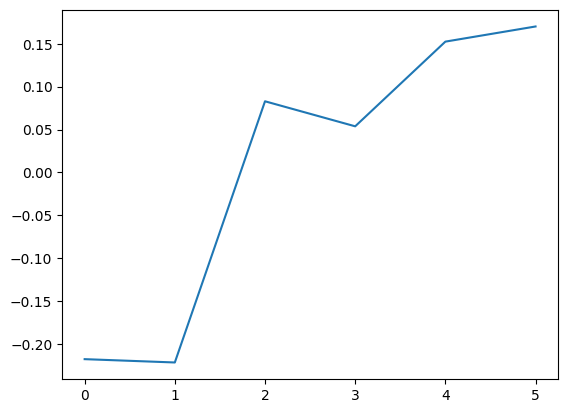

In [244]:
plt.plot(range(len(train_pcs[0])),train_pcs[0].cumsum())

In [245]:
X_reg_train.shape

(53759, 6)

In [246]:
# --- 4. TimesFM Forecasting of PCs ---

# Load TimesFM model (using CPU as GPU setup for TimesFM might be complex)
# You might need to specify the model path if not using default download.
# Ensure 'timesfm' is installed (pip install timesfm).


try:
    hparams = TimesFmHparams(
            backend="torch",
            context_len=CONTEXT_LEN,
            horizon_len=HORIZON_LEN,
            input_patch_len=32,
            output_patch_len=128,
            num_layers=20,
            model_dims=1280,
        )
    checkpoint = TimesFmCheckpoint(huggingface_repo_id="google/timesfm-1.0-200m-pytorch")
    tfm = timesfm.TimesFm(hparams=hparams, checkpoint=checkpoint)

except Exception as e:
    print(f"\nError loading TimesFM: {e}")
    print("Please ensure 'timesfm' is installed and checkpoint files are accessible.")
    print("You might need to manually download 'timesfm-1.0-200m-cpu.ckpt' if it doesn't auto-download.")
    exit()

# Prepare training data for regression model (PC -> RUL mapping)
# We use the *current* PCs to predict the *current* RUL for training this part
X_reg_train = train_df[[f'PC_{i+1}' for i in range(N_COMPONENTS)]].values
y_reg_train = train_df['RUL'].values

# --- 5. Regression Model Training (PCs to RUL) ---

# Using RandomForestRegressor as an example.  
rul_regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rul_regressor.fit(X_reg_train, y_reg_train)

print("\nRegression model (PCs to RUL) trained.")



Fetching 3 files: 100%|████████████████████████| 3/3 [00:00<00:00, 50131.12it/s]



Regression model (PCs to RUL) trained.


In [247]:
forecast_pcs.shape

(6, 50)

In [248]:
#rul_regressor.predict(forecast_pcs.T)[0]

In [249]:
forecast_pcs.shape

(6, 50)

In [250]:
CONTEXT_LEN

128

In [251]:
len(unit_df) < CONTEXT_LEN

True

In [252]:
# --- 6. Prediction & Evaluation on Test Data ---
from tqdm import tqdm
predicted_ruls = []

# Iterate through each test engine
for unit_no in tqdm(test_df['unit_number'].unique()):
    unit_df = test_df[test_df['unit_number'] == unit_no].copy()
    
    # Get the last CONTEXT_LEN PCs for this unit
    # Ensure there are enough cycles to form the context window
    if len(unit_df) < CONTEXT_LEN:
        # Pad if the unit has fewer cycles than context_len
        # Simple padding: repeat the first available PC vector
        padding_needed = CONTEXT_LEN - len(unit_df)
        last_n_pcs = np.vstack([unit_df[[f'PC_{i+1}' for i in range(N_COMPONENTS)]].iloc[0].values[np.newaxis,:] * np.ones((padding_needed, N_COMPONENTS)),
                                unit_df[[f'PC_{i+1}' for i in range(N_COMPONENTS)]].values])[-CONTEXT_LEN:]
    else:
        last_n_pcs = unit_df[[f'PC_{i+1}' for i in range(N_COMPONENTS)]].iloc[-CONTEXT_LEN:].values

    # TimesFM expects input shape (batch_size, num_channels, context_len)
    # Our `last_n_pcs` is (context_len, num_channels)
    # Need to reshape to (1, num_channels, context_len)
    timesfm_input = torch.tensor(last_n_pcs, dtype=torch.float32).T.unsqueeze(0) # Transpose and add batch dim

    # Forecast future PCs using TimesFM
    # The output is (batch_size, num_channels, horizon_len)
    forecast_pcs_torch, _ = tfm.forecast(timesfm_input.squeeze(), freq=[FREQ]*N_COMPONENTS)
    forecast_pcs = forecast_pcs_torch # Convert back to (horizon_len, num_channels)

    # For RUL prediction, we typically care about the RUL at the end of the
    # predicted horizon. Let's take the *last* forecasted PC vector.
    # Alternatively, you could average, or feed a sequence to an LSTM, etc.
    # For this basic implementation, we take the last forecasted PC vector.
    last_forecasted_pc_vector = forecast_pcs[-1, :].reshape(1, -1)

    # Predict RUL using the trained regression model
    predicted_rul = rul_regressor.predict(forecast_pcs.T)[0]
    predicted_ruls.append(predicted_rul)



100%|█████████████████████████████████████████| 100/100 [00:11<00:00,  8.64it/s]



--- Model Evaluation (TimesFM + PCA) ---
RMSE: 23.07
R2 Score: 0.69
NASA RUL Score: 2473.50


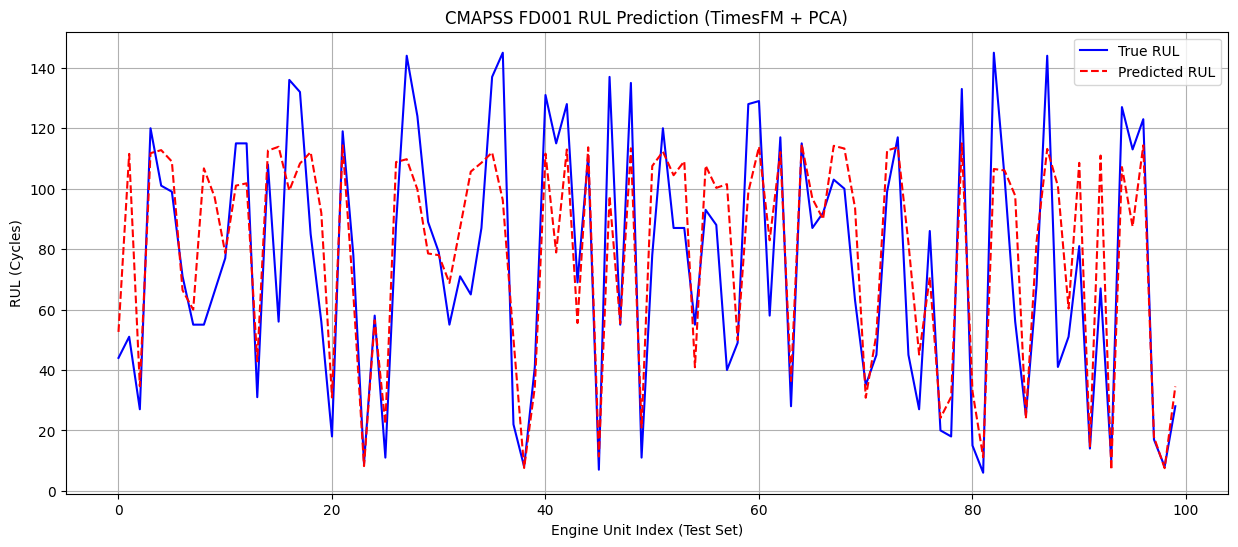

In [253]:
# Ensure predictions are non-negative
y_pred_final = np.maximum(0, np.array(predicted_ruls)).flatten()

# Get true RUL for comparison
y_true_final = rul_test_df['RUL'].values

# --- Evaluation ---

rmse = np.sqrt(mean_squared_error(y_true_final, y_pred_final))
r2 = r2_score(y_true_final, y_pred_final)

# NASA RUL Scoring Function
def nasa_rul_score(y_true, y_pred):
    d = y_pred - y_true
    score = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return score

nasa_score = nasa_rul_score(y_true_final, y_pred_final)

print(f"\n--- Model Evaluation (TimesFM + PCA) ---")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")
print(f"NASA RUL Score: {nasa_score:.2f}")

# Plotting Results
plt.figure(figsize=(15, 6))
plt.plot(y_true_final, label='True RUL', color='blue')
plt.plot(y_pred_final, label='Predicted RUL', color='red', linestyle='--')
plt.title('CMAPSS FD001 RUL Prediction (TimesFM + PCA)')
plt.xlabel('Engine Unit Index (Test Set)')
plt.ylabel('RUL (Cycles)')
plt.legend()
plt.grid(True)
plt.show()